In [1]:

import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from numpy.random import randn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option( "display.max_columns", None)

df  = pd.read_csv("breast_cancer_data.csv") 

In [3]:
df.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


In [4]:
df.shape

(569, 33)

# let see the numbers of categorical features and numerical features

In [8]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [9]:
#lets find the count of null values

df.isnull().sum().sort_values(ascending=False)

Unnamed: 32                569
area_se                      0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
smoothness_se                0
fractal_dimension_worst      0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
id      

In [10]:
df['diagnosis'] = df['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)

In [12]:
df.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)


In [13]:
df.fillna((0), inplace=True)

# Feature Selection

In [14]:
X = df.drop('diagnosis', axis = 1)
y = df.diagnosis

In [15]:
X.shape, y.shape

((569, 30), (569,))

# Univariate Feature Selection
Univariate feature selection selects the best features by running univariate statistical tests like chi-squared test, F-1 test, and mutual information methods.

In [16]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split


bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [17]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [18]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

           features          Score
23       area_worst  112598.431564
3         area_mean   53991.655924
13          area_se    8758.504705
22  perimeter_worst    3665.035416
2    perimeter_mean    2011.102864
20     radius_worst     491.689157
0       radius_mean     266.104917
12     perimeter_se     250.571896
21    texture_worst     174.449400
1      texture_mean      93.897508


# Univariate Analysis (features and target 'diagnosis')
Features distributions

In [20]:
target = 'diagnosis'
features_list = list(df.columns)
features_list.remove(target)



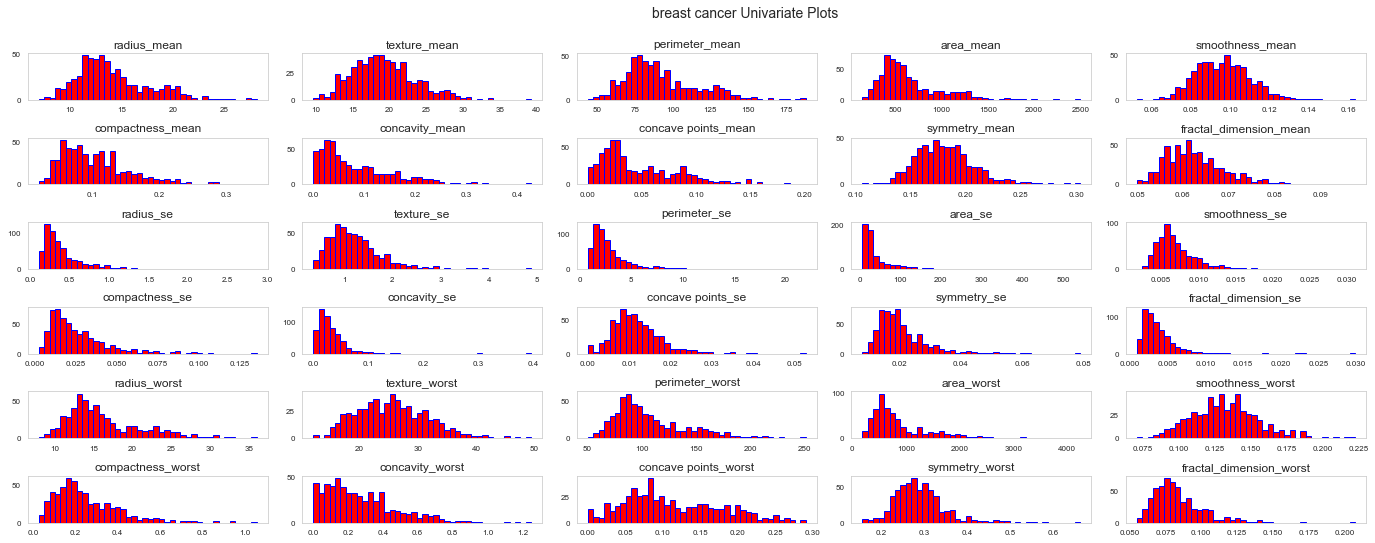

In [21]:
df[features_list].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('breast cancer Univariate Plots', x=0.65, y=1.25, fontsize=14);

# Recursive Feature Elimination (RFE)
Recursive Feature Elimination (RFE) recursively selects important subsets of features based on built-in attributes like coefficients or feature importance of a given estimator. Hence RFE heavily depends on which estimator we are using

In [27]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [33]:
def print_best_worst (scores):
    scores = sorted(scores, reverse = True)
    
    print("The 10 best features selected by this method are :")
    for i in range(10):
        print(scores[i][1])
    
    print ("The 10 worst features selected by this method are :")
    for i in range(10):
        print(scores[len(scores)-1-i][1])

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators = 50, max_depth = 4)

scores = []
num_features = len(X.columns)
for i in range(num_features):
    col = X.columns[i]
    score = np.mean(cross_val_score(clf, X[col].values.reshape(-1,1), y, cv=10))
    scores.append((int(score*100), col))

print(sorted(scores, reverse = True))

[(91, 'radius_worst'), (91, 'area_worst'), (90, 'perimeter_worst'), (90, 'concave points_worst'), (90, 'concave points_mean'), (89, 'area_mean'), (88, 'radius_mean'), (88, 'perimeter_mean'), (87, 'concavity_mean'), (86, 'area_se'), (85, 'concavity_worst'), (81, 'perimeter_se'), (79, 'radius_se'), (79, 'compactness_mean'), (78, 'compactness_worst'), (72, 'smoothness_worst'), (71, 'texture_worst'), (70, 'texture_mean'), (70, 'concave points_se'), (69, 'symmetry_worst'), (68, 'concavity_se'), (67, 'compactness_se'), (66, 'fractal_dimension_worst'), (65, 'symmetry_mean'), (65, 'smoothness_mean'), (64, 'fractal_dimension_se'), (63, 'fractal_dimension_mean'), (62, 'symmetry_se'), (61, 'texture_se'), (60, 'smoothness_se')]


# LogisticRegression features selection

In [35]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [36]:
rfe = RFE(LogisticRegression(), n_features_to_select=1)
rfe.fit(X,y)

C:\Users\ericksen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ericksen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

C:\Users\ericksen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ericksen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [37]:
scores = []
for i in range(num_features):
    scores.append((rfe.ranking_[i],X.columns[i]))
    
print_best_worst(scores)

The 10 best features selected by this method are :
smoothness_se
fractal_dimension_se
area_mean
fractal_dimension_mean
symmetry_se
concave points_se
perimeter_mean
area_worst
concavity_se
texture_mean
The 10 worst features selected by this method are :
concavity_worst
concavity_mean
compactness_worst
radius_worst
radius_mean
concave points_worst
symmetry_worst
perimeter_se
compactness_mean
concave points_mean


# note that we would be using the best ten features in trainin our model

# Feature Importance¶
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

# ExtraTreesClassifier

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [39]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers


[0.06653015 0.02030613 0.04092476 0.09666071 0.01052768 0.02611938
 0.05578632 0.06449617 0.00724273 0.00646441 0.03302961 0.00465762
 0.0191065  0.02746192 0.00664327 0.00841221 0.00894763 0.00841936
 0.0061398  0.00707109 0.08102267 0.03105162 0.09530926 0.06378198
 0.01920987 0.02706057 0.03656189 0.09241325 0.0177408  0.01090064]


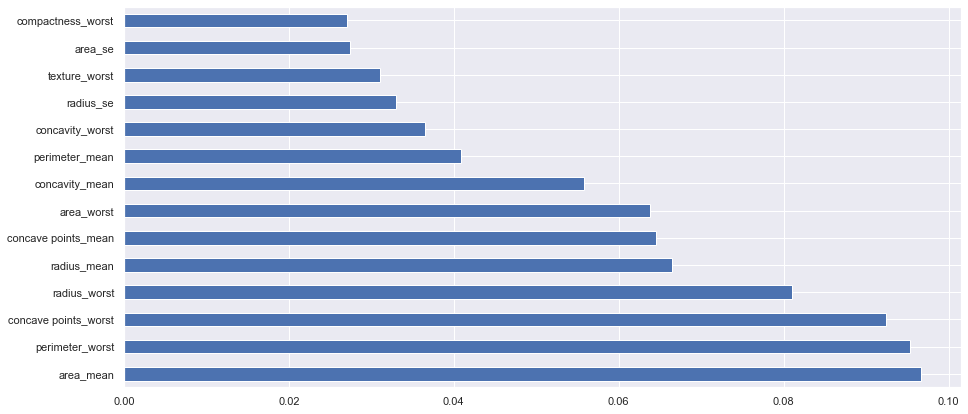

In [40]:
#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(15,7))

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

# let try Random Forest Feature Importance

In [41]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X,y)

RandomForestClassifier()

In [42]:
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers


[0.03184541 0.01408342 0.05226217 0.04742075 0.00660863 0.01307838
 0.05893928 0.05651995 0.00359705 0.00234888 0.01247755 0.00290583
 0.00921978 0.0274901  0.00532603 0.00361511 0.00751094 0.00452633
 0.00354096 0.00424407 0.12833801 0.01907251 0.17862318 0.10785201
 0.01714424 0.0097739  0.02546245 0.1263923  0.01262339 0.00715738]


In [43]:
scores = []
for i in range(num_features):
    scores.append((clf.feature_importances_[i],X.columns[i]))
        
print_best_worst(scores)

The 10 best features selected by this method are :
perimeter_worst
radius_worst
concave points_worst
area_worst
concavity_mean
concave points_mean
perimeter_mean
area_mean
radius_mean
area_se
The 10 worst features selected by this method are :
fractal_dimension_mean
texture_se
symmetry_se
symmetry_mean
compactness_se
fractal_dimension_se
concave points_se
smoothness_se
smoothness_mean
fractal_dimension_worst


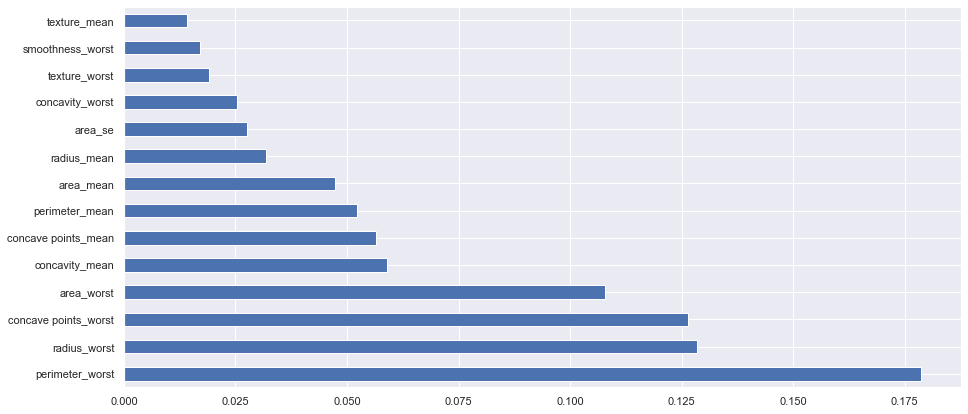

In [44]:
#plot graph of feature importances for better visualization
fig, ax = plt.subplots(figsize=(15,7))

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

# XGBoost Feature Importance
The XGBoost library provides a built-in function to plot features ordered by their importance.

The function is called plot_importance()

In [48]:

from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
model.fit(X, y)
score = model.score(X, y)

C:\Users\ericksen\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:09:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


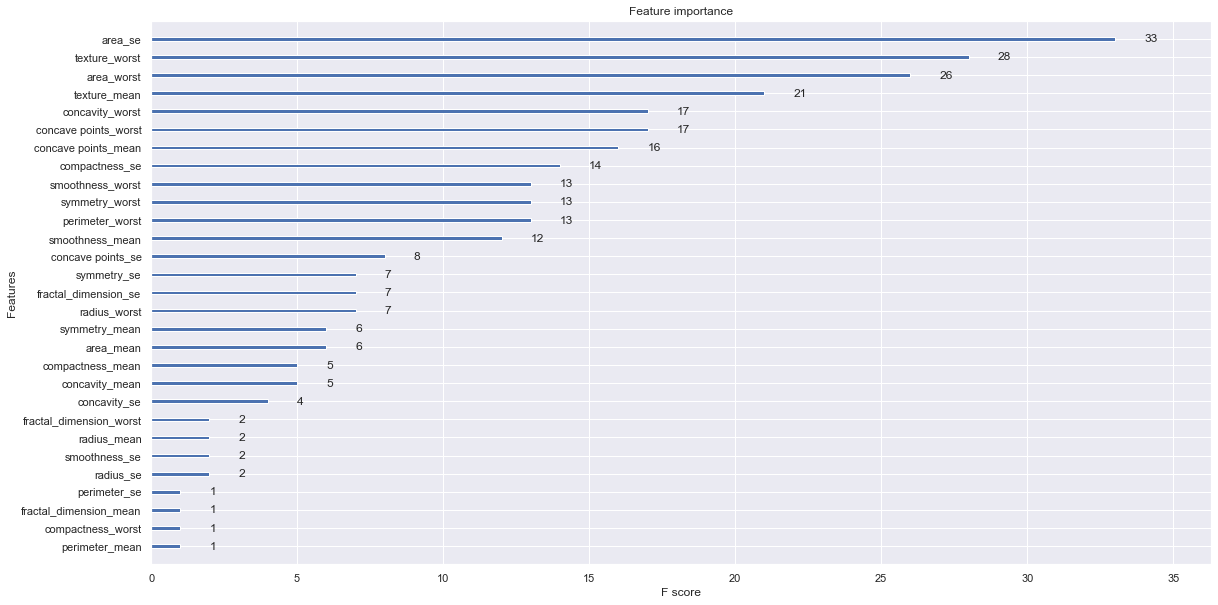

In [49]:
from xgboost import plot_importance
from matplotlib import pyplot


plt.rcParams['figure.figsize'] = (19, 10)

plot_importance(model)

pyplot.show()

# Correlation Matrix with Heatmap
Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

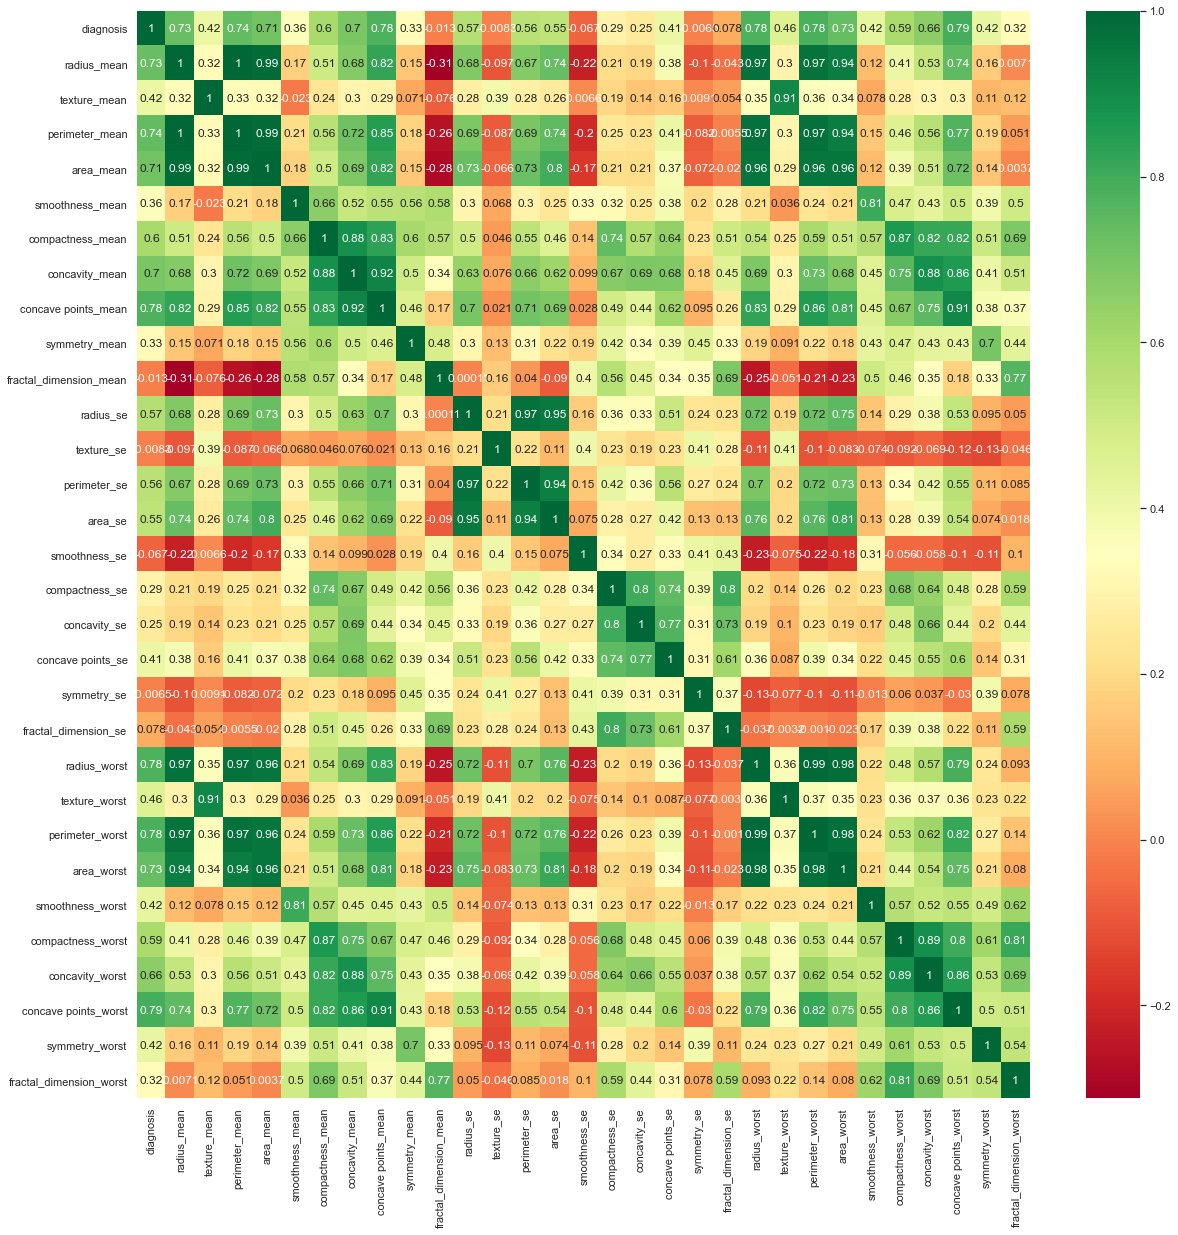

In [51]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index                                    
plt.figure(figsize=(20,20))                                  
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# dealing with Outliers

In [52]:
def outlier(df):
        df1 = df.copy()
        df = df._get_numeric_data()


        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        for col in df.columns:
            for i in range(0,len(df[col])):
                if df[col][i] < lower_bound[col]:            
                    df[col][i] = lower_bound[col]

                if df[col][i] > upper_bound[col]:            
                    df[col][i] = upper_bound[col]    


        for col in df.columns:
            df1[col] = df[col]

        return(df1)

df = outlier(df)

<ipython-input-52-814fb4667861>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = upper_bound[col]
<ipython-input-52-814fb4667861>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = lower_bound[col]


# predictive analysis
many companies still use the traditional model(Logistic or Linear Regression) for deciding their businesses due to their interpretable nature. Recent research and much winning data hackathon solutions show the Gradient Boosting Algorithm(Lightgbm, Catboost, and Xgboost) are more robust than the traditional model.

# FOR THE MODEL PREDICTION, WE WOULD BE USING LIGHTGBM model
lightGBM is a gradient boosting framework that makes use of tree based learning algorithms that is considered to be a very powerful algorithm when it comes to computation.

It has become difficult for the traditional algorithms to give results fast, as the size of the data is increasing rapidly day by day. LightGBM is called “Light” because of its computation power and giving results faster. It takes less memory to run and is able to deal with large amounts of data.

LightGBM is not for a small volume of datasets. It can easily overfit small data due to its sensitivity. It can be used for data having more than 10,000+ rows. There is no fixed threshold that helps in deciding the usage of LightGBM. It can be used for large volumes of data especially when one needs to achieve a high accuracy.

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix,plot_roc_curve
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [54]:
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = -1
    params["num_leaves"] = 10
    params["min_data_in_leaf"] = 20
    params["learning_rate"] = 0.03
    params["bagging_fraction"] = 0.9
    params["feature_fraction"] = 0.35
    params["feature_fraction_seed"] = 20
    params["bagging_freq"] = 10
    params["bagging_seed"] = 30
    params["'min_child_weight'"] = 0.09
    params["lambda_l1"] = 0.01
    params["verbosity"] = -1
from lightgbm import LGBMClassifier # intializing the model
model = LGBMClassifier(**params)
# fitting the model
model.fit(X_train,y_train)

[LightGBM] [Warning] min_child_weight is set=0.001, min_child_weight=0.09 will be ignored. Current value: min_child_weight=0.001
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


LGBMClassifier("'min_child_weight'"=0.09, bagging_fraction=0.9, bagging_freq=10,
               bagging_seed=30, feature_fraction=0.35, feature_fraction_seed=20,
               lambda_l1=0.01, learning_rate=0.03, metric='auc',
               min_data_in_leaf=20, num_leaves=10, objective='binary',
               verbosity=-1)

In [55]:
y_pred = model.predict(X_test)


In [56]:
print("Testing Accuracy :", model.score(X_test, y_test))
print("Training Accuracy :", model.score(X_train,y_train))

Testing Accuracy : 0.956140350877193
Training Accuracy : 0.9912087912087912


In [57]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred = [ 1 if y>=0.5 else 0 for y in Y_pred]

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
print(cm)

[[76  4]
 [ 1 33]]


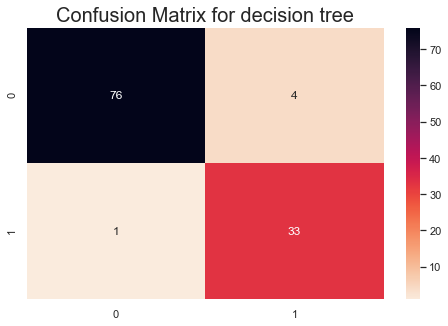

In [59]:
# plottinhg the confusion matrix

plt.rcParams['figure.figsize'] = (8, 5)
sns.heatmap(cm, annot = True, cmap = 'rocket_r')
plt.title('Confusion Matrix for decision tree', fontweight = 30, fontsize = 20)
plt.show()

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        80
           1       0.89      0.97      0.93        34

    accuracy                           0.96       114
   macro avg       0.94      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [61]:
LGB_y_prob = model.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(LGB_y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(X_test, y_pred)

1.0

In [62]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, LGB_y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9900735294117647

Text(0.5, 0, 'False Positive Rate')

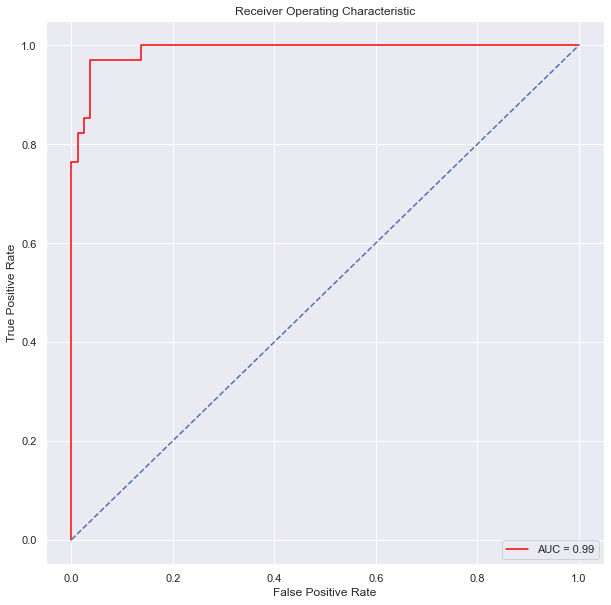

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# MODEL EXPLAINABILITY / INTERPRETABILITY
What is explainable AI? Explainable AI methods, such as LIME, allow to explain and interpret the predictions of machine learning models. They offer a solution for the trade-off between interpretability and performance, i. e. between complex models that can handle large and versatile data sets and less complex models that are much easier to interpret, but usually also less performant.

In short, they provide insight into the criteria behind predictions of machine learning models.

Interpretability delineates the passive feature of a learning model referring to the extent at which a given learning model makes sense to a user. Explainability is an active feature of a learning model describing the processes undertaken by the learning model with the intent of clarifying the inner working of the learning model. It is related to the notion of an argument or explanation where there is an interface between the user and the decision-maker.

# ELI5 Model Interpretation
According to their documentation, ELI5 ("Explain Like I'm 5") is a Python library which helps to debug machine learning classifiers and regressors and explain their predictions in an easy to understand an intuitive way. ELI5 is a good starting point and support tree-based and parametric/linear models and also text processing and HashingVectorizer utilities from scikit-learn but doesn't support true model-agnostic interpretations.

In [66]:
import eli5
from eli5.sklearn import PermutationImportance

In [67]:
target = 'diagnosis'
features_list = list(df.columns)
features_list.remove(target)

In [68]:
#best features are arrange from top to the least important feature

eli5.show_weights(model, feature_names=features_list)

Weight,Feature
0.2490,perimeter_worst
0.1795,area_worst
0.1383,radius_worst
0.1127,concave points_worst
0.0633,concave points_mean
0.0509,area_mean
0.0414,perimeter_mean
0.0242,area_se
0.0239,texture_worst
0.0192,concavity_worst


In [69]:
eli5.show_prediction(model, X_test.iloc[i], feature_names=features_list, show_feature_values=True)

# SHAP MODEL EXPLAINABILITY
SHAP stands for SHapley Additive exPlanations. The core idea behind Shapley value-based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model’s output f(x)f(x) among its input features. In order to connect game theory with machine learning models it is necessary to both match a model’s input features with players in a game, and also match the model function with the rules of the game.

In [70]:
from xgboost import XGBClassifier

models = XGBClassifier(random_state=42)
models.fit(X_train, y_train)
score = models.score(X_test, y_test)

C:\Users\ericksen\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:28:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [73]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [74]:
#initiate Javascript
shap.initjs()

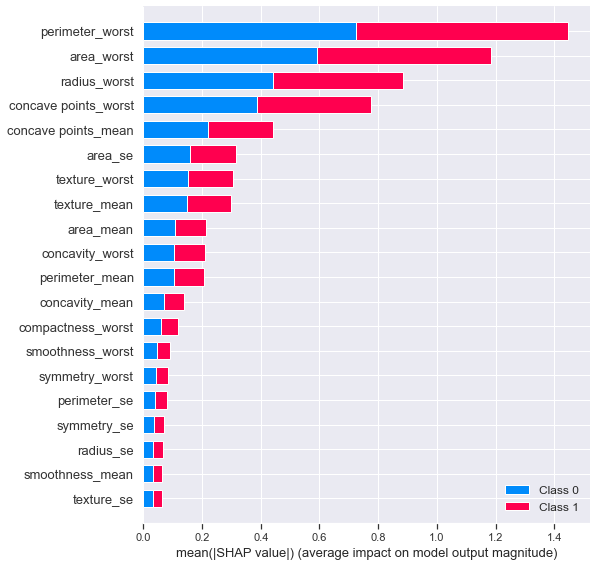

In [85]:
#The color represents the feature value — red indicating high and blue indicating low
shap.summary_plot(shap_values, X)

# lime model interpretability
The explainable AI method LIME (Local Interpretable Model-agnostic Explanations) helps to illuminate a machine learning model and to make its predictions individually comprehensible. The method explains the classifier for a specific single instance and is therefore suitable for local explanations.

In [88]:
from lime.lime_tabular import LimeTabularExplainer

In [91]:
features_list = list(df.columns)


In [94]:

#instantiate the explanations for the data set
limeexplainer = LimeTabularExplainer(X_test.values, 
                                     class_names=['Will pay','Will not pay'], feature_names = X_test.columns, discretize_continuous = True)
idx=1 # the rows of the dataset
explainable_exp = limeexplainer.explain_instance(X_test.values[idx], model.predict_proba, num_features=10, labels=class_names)
explainable_exp.show_in_notebook(show_table=True, show_all=False)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices